In [1]:
import numpy as np
import struct
from scipy.stats import pearsonr
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import resample

# Load the data
avg_entries = np.load("avg_entries.npy")
subset_traces = np.load("avg_traces.npy")

# Select 3000 inputs and their corresponding traces without limiting the number of points
selected_avg_entries = avg_entries[:3000]
selected_subset_traces = subset_traces[:3000]

# Resample the traces to 5000 points
resampled_subset_traces = resample(selected_subset_traces, 5000, axis=1)

# Data cleaning: Remove NaN and extreme values
# Remove NaN values from selected_avg_entries
nan_indices = np.argwhere(np.isnan(selected_avg_entries))
cleaned_avg_entries = np.delete(selected_avg_entries, nan_indices, axis=0)

# Remove corresponding traces
cleaned_subset_traces = np.delete(resampled_subset_traces, nan_indices, axis=0)

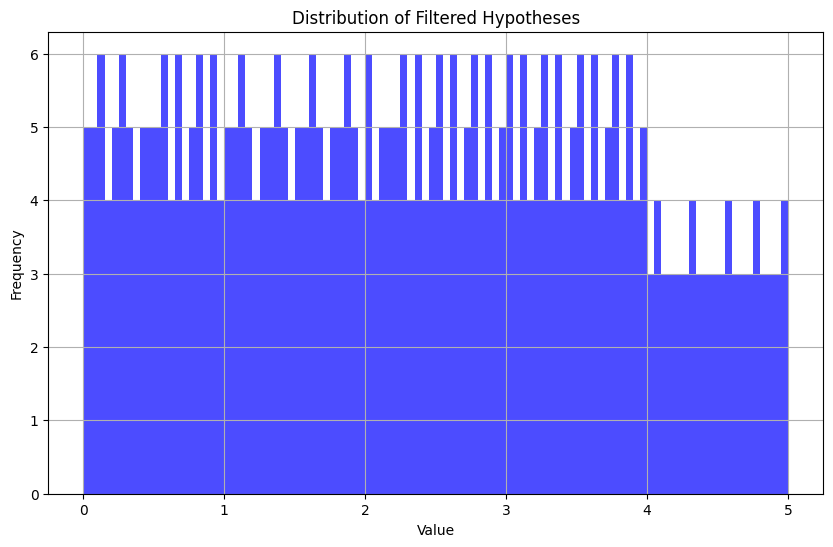

(465, [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

In [2]:
# Define the precision threshold for filtering
precision_threshold = 0.01

# Define the range for NN weights (for this example, we'll use 0 to 5)
min_value = 0
max_value = 5

# Generate hypotheses
unique_values = set()
for exponent in range(256):  # 8 bits for the exponent
    for mantissa in range(256):  # 8 most significant bits for the mantissa
        # Construct the binary representation of the float
        binary_str = '0' + format(exponent, '08b') + format(mantissa, '08b') + '0' * 15
        float_num = struct.unpack('!f', struct.pack('!I', int(binary_str, 2)))[0]
        rounded_num = round(float_num, 2)
        if min_value <= rounded_num <= max_value:
            unique_values.add(rounded_num)

# Convert the set of unique values to a sorted list
hypotheses_list = sorted(list(unique_values))

# Plot the filtered and rounded hypotheses
plt.figure(figsize=(10, 6))
plt.hist(hypotheses_list, bins=100, color='blue', alpha=0.7)
plt.title('Distribution of Filtered Hypotheses')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Output the number of unique values for verification
len(hypotheses_list), hypotheses_list[:10]  # Show the first 10 hypotheses for inspection

In [3]:
# Define functions for CPA analysis
def float_to_binary(num):
    """Convert a floating point number to its binary representation in IEEE 754 format."""
    return ''.join(f'{c:08b}' for c in struct.pack('!f', num))

def hamming_weight(binary_str):
    """Calculate the Hamming weight (number of '1's) in the binary string."""
    return binary_str.count('1')

def calculate_correlations_for_weight(traces, inputs, weight):
    hws = [hamming_weight(float_to_binary(input_value * weight)) for input_value in inputs]
    correlations = np.array([pearsonr(traces[:, sample_point], hws)[0] for sample_point in range(traces.shape[1])])
    correlations = np.nan_to_num(correlations)
    return correlations

# Hypothetical weights range
hypothetical_weights = hypotheses_list

# Using joblib to parallelize the correlation calculation
num_cores = 12
with tqdm(total=len(hypothetical_weights)) as progress_bar:
    results = Parallel(n_jobs=num_cores)(delayed(calculate_correlations_for_weight)(cleaned_subset_traces, cleaned_avg_entries, weight) for weight in tqdm(hypothetical_weights))
    progress_bar.update()

# Combine the results
correlations = np.array(results)

# Find the index of the maximum correlation
max_corr_index = np.unravel_index(np.argmax(correlations, axis=None), correlations.shape)

# Extracting the most likely weight
most_likely_weight = hypothetical_weights[max_corr_index[0]]

print("Most Likely Weight:", most_likely_weight)

# Plotting function for correlation scores
def plot_correlations(hypothetical_weights, correlations):
    plt.figure(figsize=(12, 6))
    for i in range(correlations.shape[1]):
        plt.plot(hypothetical_weights, correlations[:, i], label=f'Point {i}')
    plt.title('Correlation Scores for the Multiplication')
    plt.xlabel('Hypothetical Weight')
    plt.ylabel('Correlation Score')
    plt.legend()
    plt.show()

# Plot the correlations
plot_correlations(hypothetical_weights, correlations)

  0%|          | 0/465 [00:00<?, ?it/s]

  0%|          | 0/465 [00:00<?, ?it/s]

Most Likely Weight: 1.0


C:\Users\zqde8\CHIPWH~1\cw\home\portable\WPy64-31080\python-3.10.8.amd64\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 1012x104775 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x600 with 1 Axes>